In [1]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy import stats

In [2]:
fw_fn = "fineweb-results-{flavour}.json"
ask_fn = "askllm-scores-{lang}-{flavour}.npy"

In [3]:
langs = ["sv", "no", "da"]
flavours = ["c4", "oscar", "hplt"]
sizes = ["8b", "70b"]
base_key = "ScandLM/fineweb-{size}-{lang}"

In [4]:
askllm_data = {}
for lang in langs:
    askllm_data[lang] = {}
    for flavour in flavours:
        askllm_data[lang][flavour] = {}
        data = np.load(ask_fn.format(lang=lang, flavour=flavour))
        askllm_data[lang][flavour]["8b"] = data * 5

In [5]:
fineweb_data = {}
for lang in langs:
    fineweb_data[lang] = {}
    for flavour in flavours:
        fineweb_data[lang][flavour] = {}
        _flavour = "m" + flavour if flavour == "c4" else flavour
        with open(fw_fn.format(flavour=_flavour)) as fh:
            _data = json.load(fh)
        for size in sizes:
            if flavour == "hplt" and size == "70b":
                continue
            d = _data[base_key.format(size=size, lang=lang)]["scores"]
            xs = np.array([x for k,v in d.items() for x in [int(k)]*v])
            fineweb_data[lang][flavour][size] = xs
            

In [6]:
def plot_hist(data, label, fig=None, ax=None, offset=0, pct=False):
    if fig is None:
        fig, ax = plt.subplots()
    cnts, bins = np.histogram(data, 40)
    width = 0.7 * (bins[1] - bins[0])
    offset *= width
    center = (bins[:-1] + bins[1:]) / 2 + offset
    if pct:
        normalizer = np.sum(cnts)
    else:
        normalizer = 1
    ax.bar(center, cnts / normalizer, width=width, align="center", label=label)
    #ax.plot(center, cnts / normalizer, label=label, marker="x")
    ax.legend()
    #plt.show()
    return fig, ax

def plot_all(pct=False):
    for lang in langs:
        for flavour in flavours:
            fig, ax = plot_hist(askllm_data[lang][flavour]["8b"], "askllm", pct=pct)
            ax.set_title(lang + "_" + flavour)
            plot_hist(fineweb_data[lang][flavour]["8b"], "fw8b", fig, ax, offset=1, pct=pct)
            if flavour == "hplt":
                continue
            plot_hist(fineweb_data[lang][flavour]["70b"], "fw70b", fig, ax, offset=2, pct=pct)

def plot_all_in_lang(pct=False):
    for lang in langs:
        fig, ax = plt.subplots()
        offset = 0
        for flavour in flavours:
            fig, ax = plot_hist(askllm_data[lang][flavour]["8b"], f"askllm-{flavour}", fig, ax, pct=pct)
            offset += 1
            ax.set_title(lang + "_" + flavour)
            fig, ax = plot_hist(fineweb_data[lang][flavour]["8b"], f"fw8b-{flavour}", fig, ax, offset=offset, pct=pct)
            offset += 1
            if flavour == "hplt":
                continue
            fig, ax = plot_hist(fineweb_data[lang][flavour]["70b"], f"fw70b-{flavour}", fig, ax, offset=offset, pct=pct)
            offset += 1
        

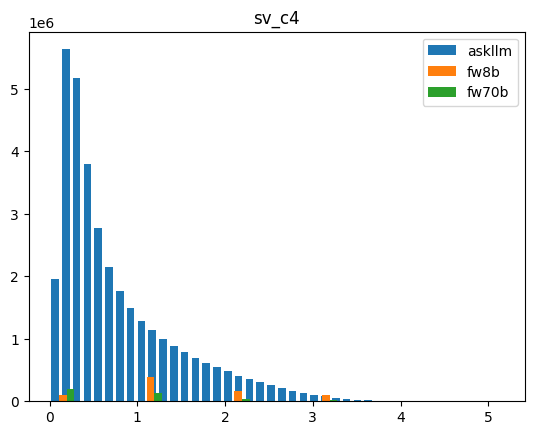

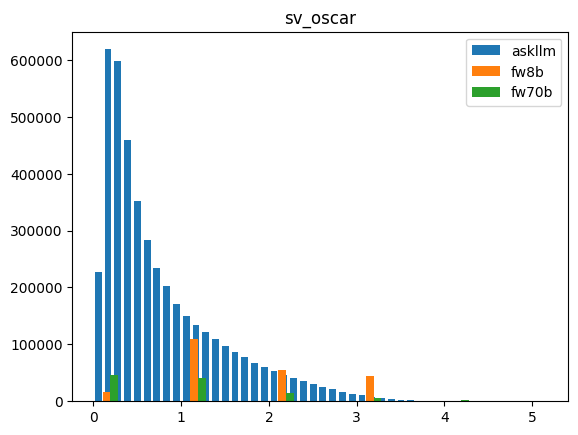

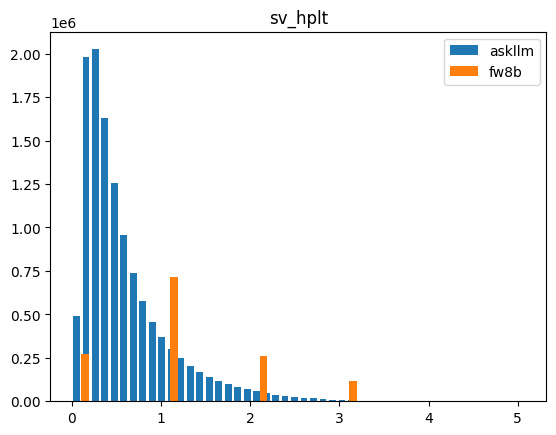

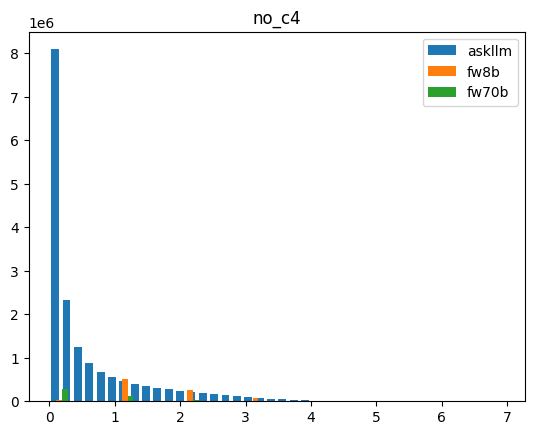

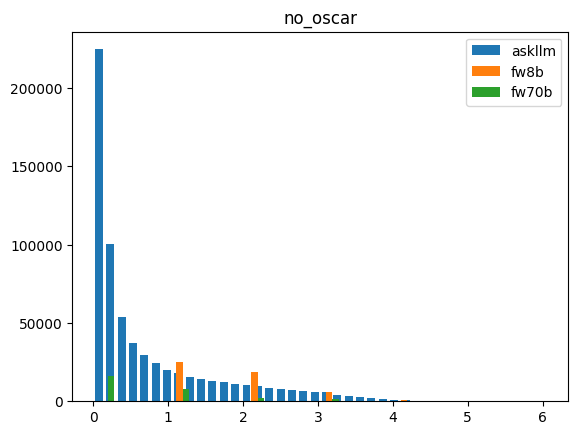

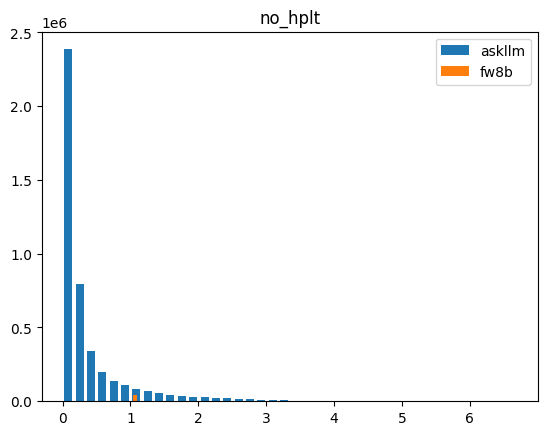

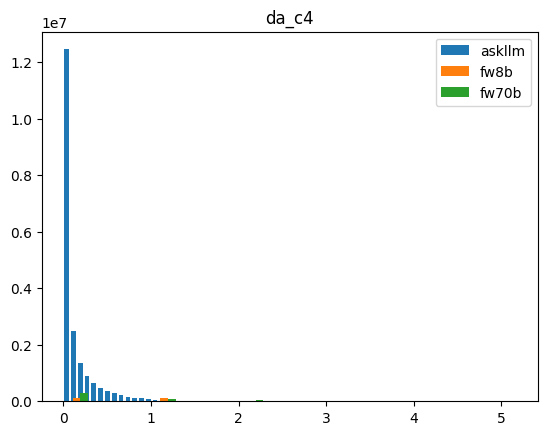

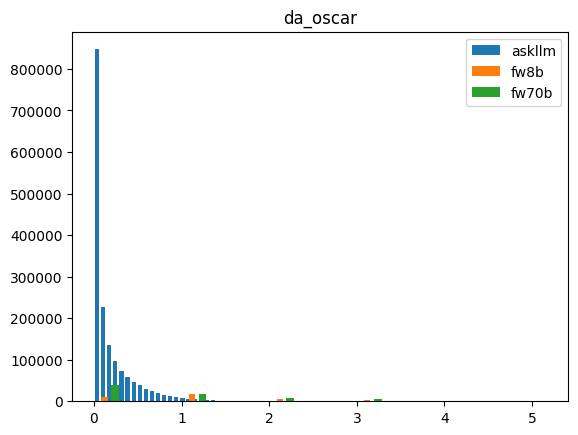

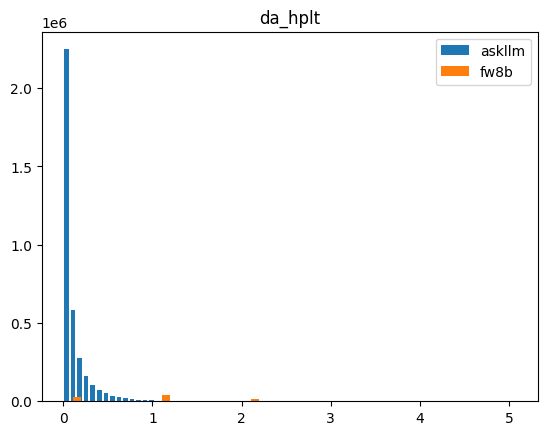

In [7]:
plot_all(False)

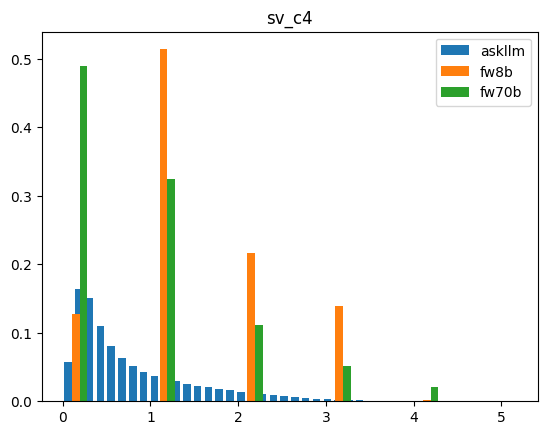

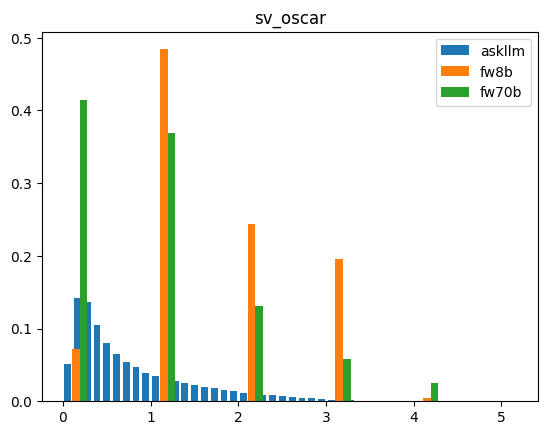

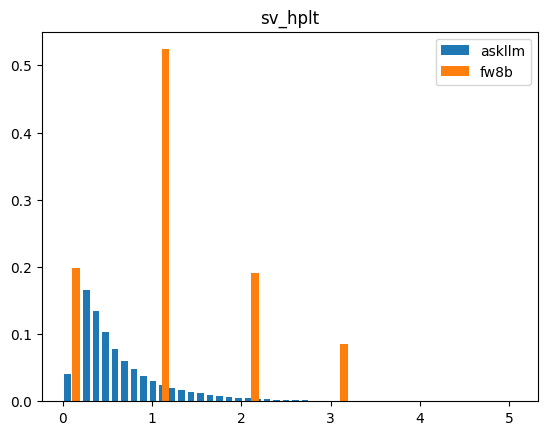

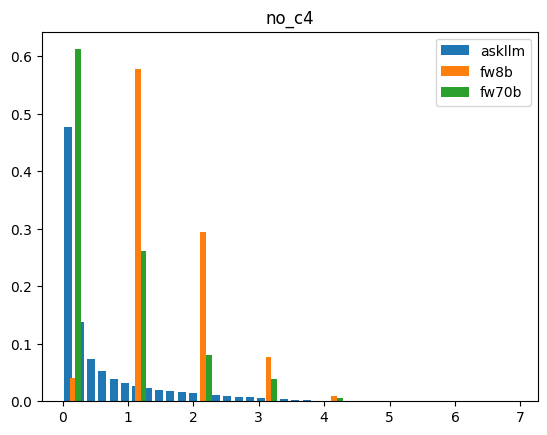

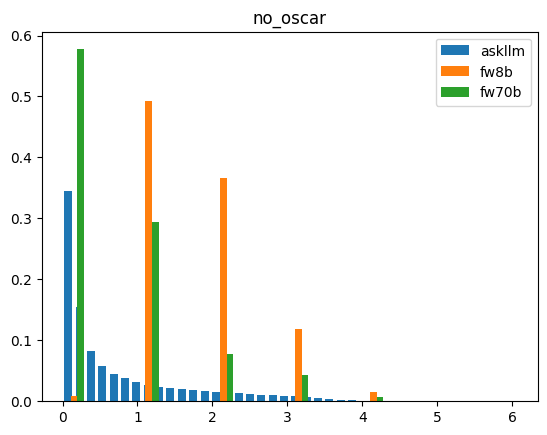

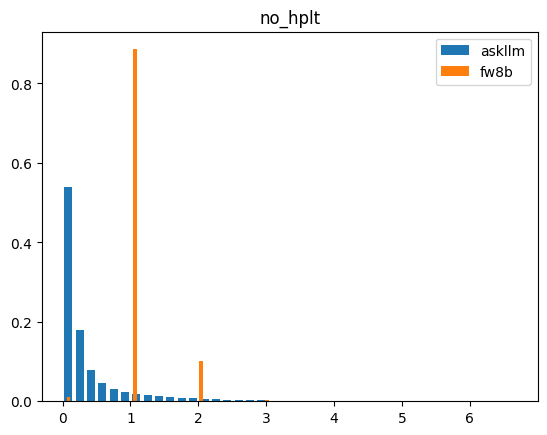

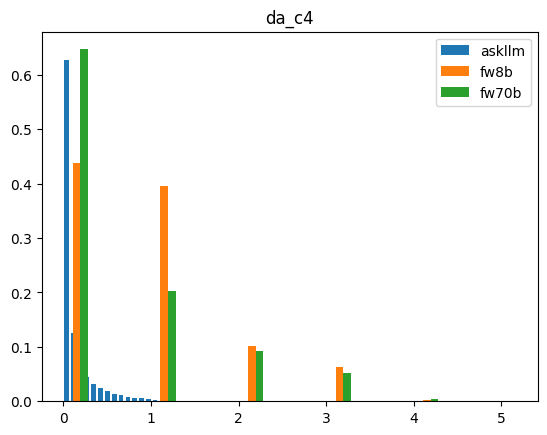

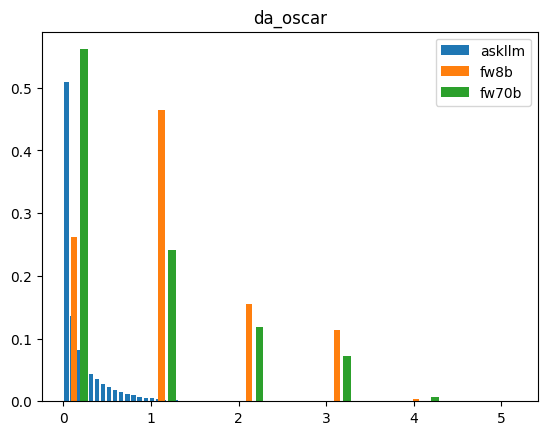

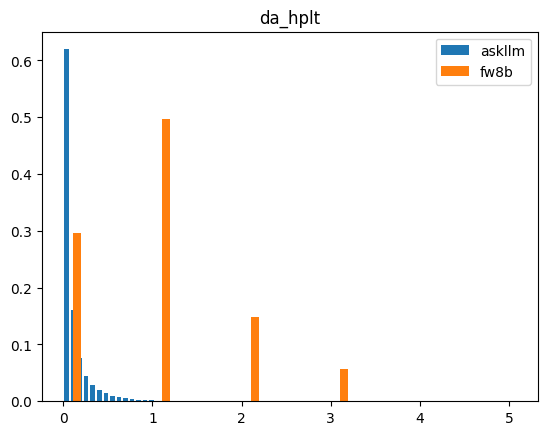

In [8]:
plot_all(True)

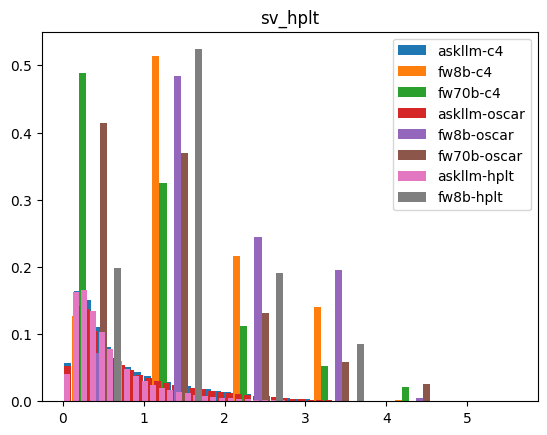

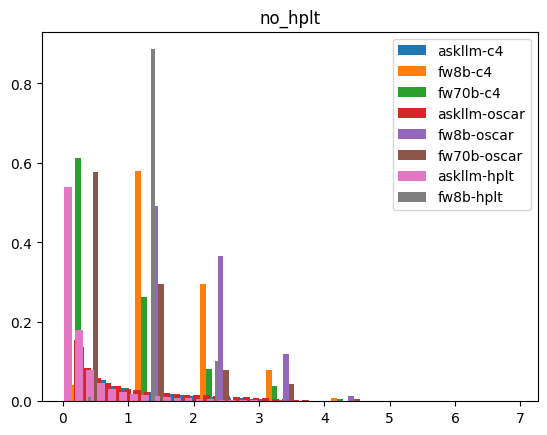

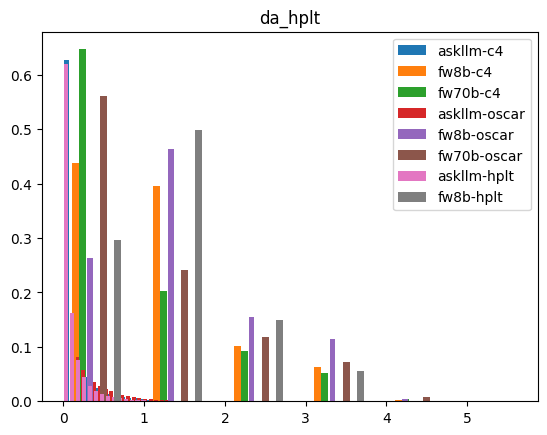

In [9]:
plot_all_in_lang(True)

In [17]:
all_scores_base = "paired-{lang}_{flavour}.json"
def neither_none(a, b):
    if a is None:
        return False
    if b is None:
        return False
    return True

def get_pairs(lang, flavour):
    fw_fw = []
    fw8_ask = []
    fw70_ask = []
    fw70_og = []
    fname = all_scores_base.format(lang=lang, flavour=flavour)
    print(fname)
    with open(fname) as fh:
        d = json.load(fh)
    for k, v in d.items():
        fw8 = v["fw8b"]
        fw70 = v["fw70b"]
        og = v["fw70b_og"]
        ask = v["askllm"]
        if neither_none(fw8, fw70):
            fw_fw.append((fw8, fw70))
        if neither_none(fw8, ask):
            fw8_ask.append((fw8, ask))
        if neither_none(fw70, ask):
            fw70_ask.append((fw70, ask))
        if neither_none(fw70, og):
            fw70_og.append((fw70, og))
    return fw_fw, fw8_ask, fw70_ask, fw70_og

In [12]:
def convert_to_d(pairs):
    d = defaultdict(list)
    for k, v in pairs:
        d[k].append(v)
    return d


In [13]:
def fw_v_ask(d):
    for k in range(6):
        v = d[k]
        print("{} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:6d}".format(k, np.mean(v), np.median(v), np.min(v), np.max(v), np.std(v), len(v)))

In [18]:
def compare_all(lang, flavour):
    fwfw, fw8ask, fw70ask, fw70og = get_pairs(lang, flavour)
    fw8ask_d = convert_to_d(fw8ask)
    fw70ask_d  = convert_to_d(fw70ask)

    try:
        print("fw8b vs askllm")
        pb = stats.pointbiserialr(*zip(*fw8ask))
        print(pb)
        fw_v_ask(fw8ask_d)
        fig, ax = plt.subplots()
        ax.boxplot([fw8ask_d[k] for k in range(6)])
        ax.violinplot([fw8ask_d[k] for k in range(6)])
        plt.show()
    except Exception as e:
        pass

    try:
        print("fw70b vs askllm")
        pb = stats.pointbiserialr(*zip(*fw70ask))
        print(pb)
        fw_v_ask(fw70ask_d)
        fig, ax = plt.subplots()
        ax.boxplot([fw8ask_d[k] for k in range(6)])
        ax.violinplot([fw8ask_d[k] for k in range(6)])
        plt.show()
    except Exception as e:
        pass

    try:
        print("fw8b vs fw70b")
        pr = stats.pearsonr(*zip(*fwfw))
        print(pr)
        y, y_hat = zip(*fwfw)
        cm = confusion_matrix(y, y_hat, labels=range(6), normalize="true")
        print(np.round(cm, 2))
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.show()
    except Exception as e:
        pass
    
    try:
        print("fw70b vs og")
        pr = stats.pearsonr(*zip(*fw70og))
        print(pr)
        y, y_hat = zip(*fw70og)
        cm = confusion_matrix(y, y_hat, labels=range(6), normalize="true")
        print(cm.round(2))
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.show()
    except Exception as e:
        pass


sv
c4
paired-sv_c4.json
fw8b vs askllm
SignificanceResult(statistic=0.5612630291374823, pvalue=0.0)
0 0.0563 0.0461 0.0001 0.5942 0.0412  97122
1 0.1135 0.0819 0.0000 0.7885 0.0958 391929
2 0.2103 0.1795 0.0016 0.8237 0.1403 164811
3 0.3021 0.2878 0.0031 0.8681 0.1552 106641
4 0.3933 0.3975 0.0374 0.7862 0.1581   1839
5 0.3636 0.3626 0.1454 0.7175 0.1645     26


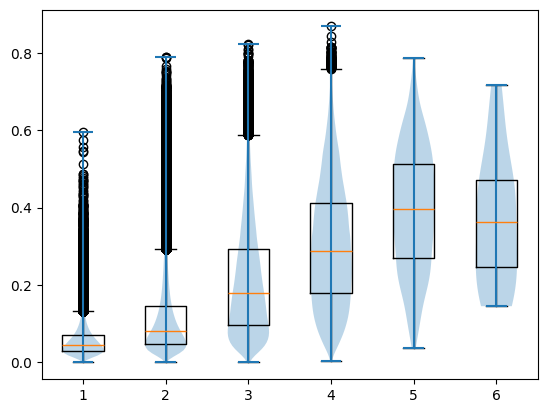

fw70b vs askllm
SignificanceResult(statistic=0.5518235077448878, pvalue=0.0)
0 0.0904 0.0643 0.0000 0.7882 0.0817 189481
1 0.1760 0.1399 0.0000 0.8104 0.1301 125999
2 0.2466 0.2247 0.0045 0.8033 0.1431  43328
3 0.3207 0.3066 0.0061 0.8159 0.1601  20110
4 0.3817 0.3822 0.0086 0.8432 0.1514   8301
5 0.4029 0.4069 0.0144 0.7686 0.1583    244


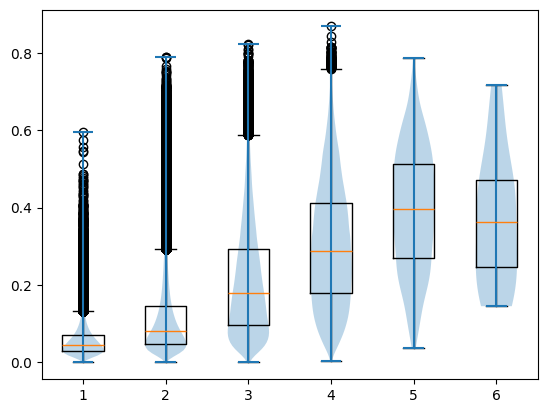

fw8b vs fw70b
PearsonRResult(statistic=0.6987310619987102, pvalue=0.0)
[[0.96 0.04 0.   0.   0.   0.  ]
 [0.63 0.33 0.03 0.   0.   0.  ]
 [0.17 0.53 0.23 0.06 0.01 0.  ]
 [0.03 0.23 0.34 0.26 0.14 0.  ]
 [0.   0.05 0.15 0.21 0.52 0.06]
 [0.   0.   0.2  0.3  0.5  0.  ]]


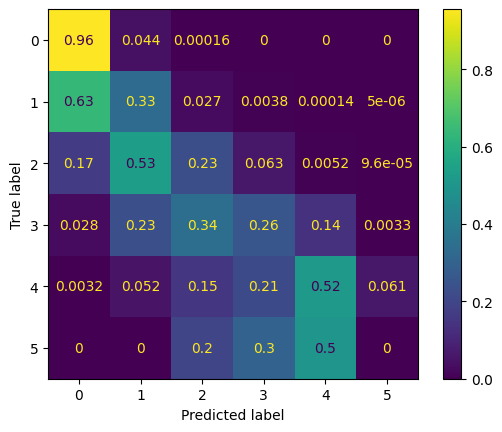

fw70b vs og
PearsonRResult(statistic=0.7654587525768518, pvalue=0.0)
[[0.46 0.52 0.02 0.   0.   0.  ]
 [0.03 0.67 0.29 0.01 0.   0.  ]
 [0.   0.19 0.63 0.16 0.02 0.  ]
 [0.   0.06 0.42 0.37 0.15 0.  ]
 [0.   0.04 0.17 0.22 0.55 0.02]
 [0.   0.   0.   0.   1.   0.  ]]


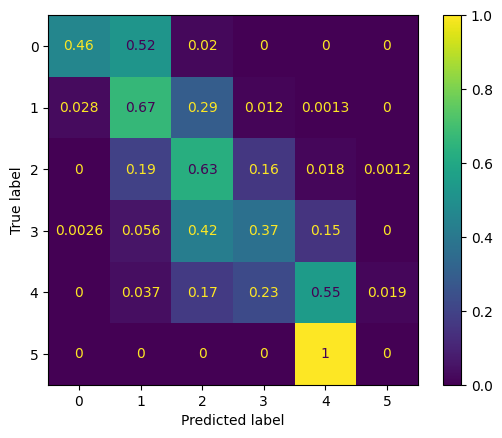

oscar
paired-sv_oscar.json
fw8b vs askllm
SignificanceResult(statistic=0.5381358235536524, pvalue=0.0)
0 0.0487 0.0385 0.0016 0.4787 0.0384  14530
1 0.1037 0.0735 0.0015 0.7453 0.0912  96847
2 0.1867 0.1536 0.0004 0.7739 0.1308  48561
3 0.2760 0.2572 0.0023 0.7958 0.1542  39101
4 0.3668 0.3711 0.0262 0.7973 0.1588    857
5 0.3378 0.2995 0.0828 0.6472 0.1464     21


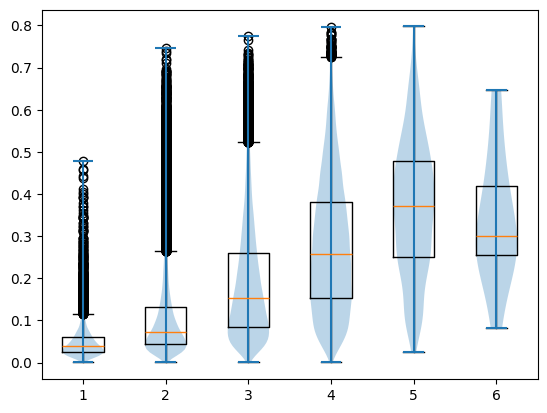

fw70b vs askllm
SignificanceResult(statistic=0.5017004815059107, pvalue=0.0)
0 0.0925 0.0630 0.0016 0.7350 0.0872  41569
1 0.1614 0.1236 0.0026 0.7851 0.1260  36841
2 0.2285 0.2025 0.0004 0.7776 0.1426  13133
3 0.3035 0.2894 0.0104 0.7767 0.1593   5848
4 0.3514 0.3511 0.0097 0.7973 0.1546   2516
5 0.3733 0.3822 0.0602 0.7068 0.1477     92


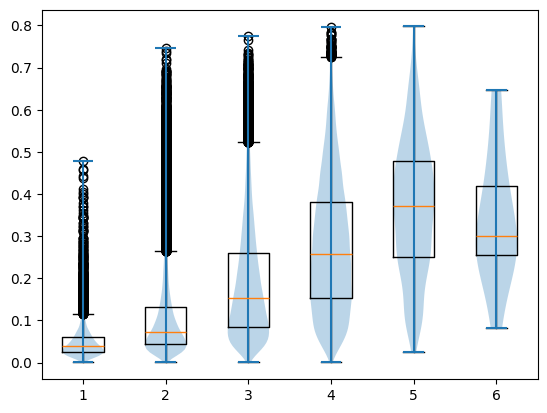

fw8b vs fw70b
PearsonRResult(statistic=0.690551953296691, pvalue=0.0)
[[0.94 0.06 0.   0.   0.   0.  ]
 [0.62 0.35 0.03 0.   0.   0.  ]
 [0.16 0.58 0.21 0.04 0.   0.  ]
 [0.04 0.27 0.34 0.23 0.12 0.  ]
 [0.01 0.06 0.2  0.23 0.42 0.07]
 [0.   0.15 0.31 0.15 0.31 0.08]]


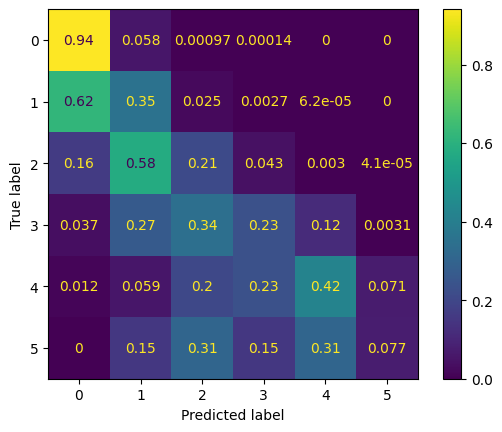

fw70b vs og
hplt
paired-sv_hplt.json
fw8b vs askllm
SignificanceResult(statistic=0.5307495332856544, pvalue=0.0)
0 0.0531 0.0448 0.0011 0.5463 0.0339 270165
1 0.1012 0.0821 0.0003 0.7343 0.0720 713655
2 0.1636 0.1385 0.0018 0.8060 0.1058 260518
3 0.2370 0.2151 0.0048 0.8178 0.1317 116811
4 0.3531 0.3559 0.0313 0.7990 0.1446   1122
5 0.3811 0.3456 0.1853 0.5669 0.1417      6


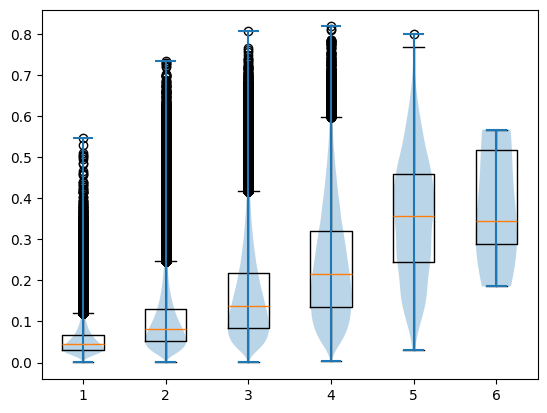

fw70b vs askllm
fw8b vs fw70b
fw70b vs og
no
c4
paired-no_c4.json
fw8b vs askllm
SignificanceResult(statistic=0.6266880422239518, pvalue=0.0)
0 0.0136 0.0091 0.0000 0.6409 0.0220  33233
1 0.0451 0.0194 0.0000 1.1863 0.0677 480197
2 0.1626 0.1120 0.0000 1.1999 0.1492 243989
3 0.3341 0.3227 0.0000 1.1314 0.1935  64353
4 0.4917 0.5062 0.0000 0.8949 0.1811   7748
5 0.5058 0.5222 0.0178 0.8681 0.1745     95


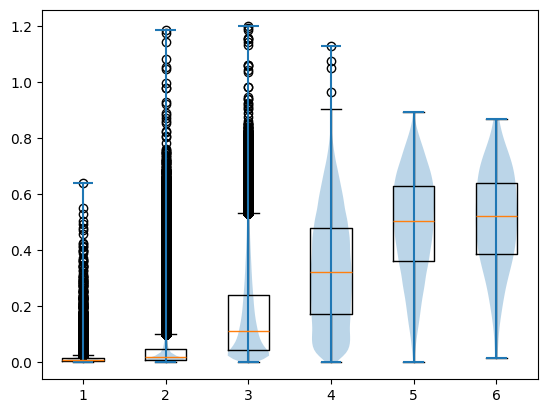

fw70b vs askllm
SignificanceResult(statistic=0.6529142906778136, pvalue=0.0)
0 0.0422 0.0180 0.0000 1.1251 0.0667 262516
1 0.1686 0.1188 0.0000 1.2312 0.1510 112073
2 0.2614 0.2280 0.0000 0.9269 0.1829  34740
3 0.4065 0.4107 0.0000 1.0764 0.1936  16426
4 0.4727 0.4834 0.0000 0.8984 0.1912   2707
5 0.4868 0.5092 0.0382 0.8543 0.1922    140


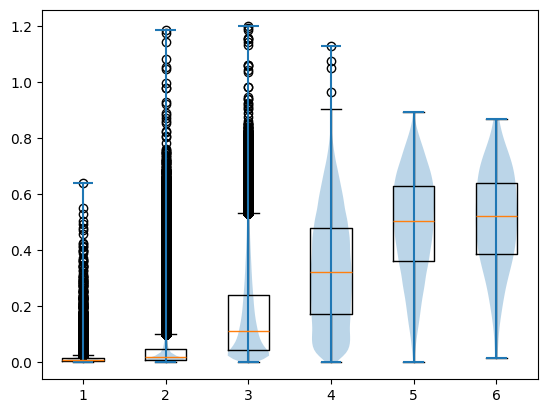

fw8b vs fw70b
PearsonRResult(statistic=0.6566383852078483, pvalue=0.0)
[[0.99 0.01 0.   0.   0.   0.  ]
 [0.84 0.14 0.01 0.   0.   0.  ]
 [0.32 0.5  0.15 0.03 0.   0.  ]
 [0.06 0.37 0.29 0.24 0.03 0.  ]
 [0.02 0.11 0.16 0.48 0.23 0.01]
 [0.   0.06 0.24 0.35 0.35 0.  ]]


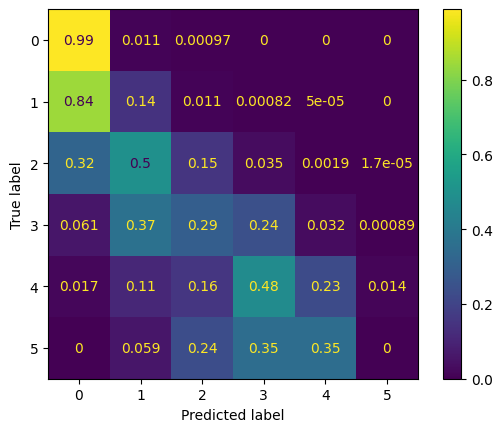

fw70b vs og
PearsonRResult(statistic=0.7453188036653668, pvalue=0.0)
[[0.4  0.55 0.04 0.   0.   0.  ]
 [0.01 0.47 0.45 0.06 0.01 0.  ]
 [0.   0.13 0.57 0.26 0.04 0.  ]
 [0.   0.03 0.2  0.35 0.41 0.02]
 [0.   0.08 0.11 0.07 0.7  0.03]
 [0.   0.   0.   0.   1.   0.  ]]


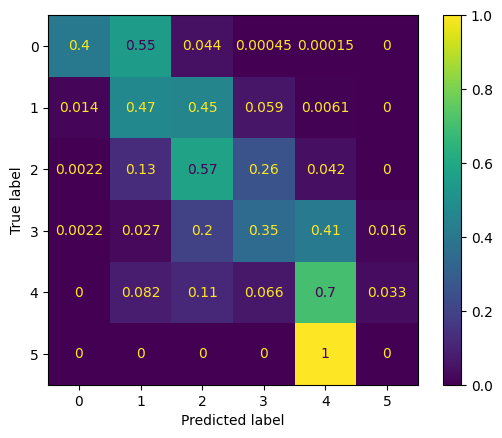

oscar
paired-no_oscar.json
fw8b vs askllm
SignificanceResult(statistic=0.6070016185717697, pvalue=0.0)
0 0.0203 0.0120 0.0011 0.2495 0.0281    431
1 0.0513 0.0232 0.0000 1.0919 0.0745  25112
2 0.1628 0.1030 0.0000 1.0278 0.1594  18709
3 0.3406 0.3314 0.0000 1.1356 0.2049   6055
4 0.4968 0.5137 0.0235 0.8516 0.1809    737
5 0.4476 0.4627 0.2751 0.6717 0.1280      6


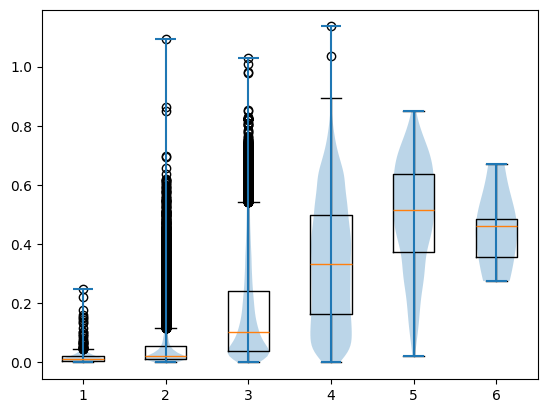

fw70b vs askllm
SignificanceResult(statistic=0.6426579876657637, pvalue=0.0)
0 0.0547 0.0252 0.0000 1.0919 0.0786  15950
1 0.1964 0.1393 0.0000 1.0771 0.1711   8132
2 0.3121 0.2852 0.0000 0.8926 0.1993   2161
3 0.4435 0.4645 0.0089 0.8400 0.1921   1192
4 0.4885 0.4999 0.0163 0.8464 0.1837    176
5 0.4237 0.4296 0.1766 0.6372 0.1231     12


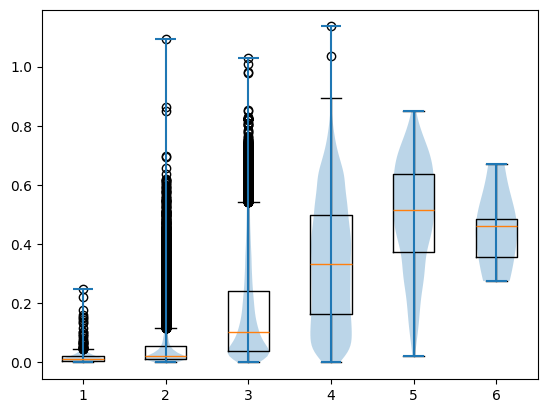

fw8b vs fw70b
PearsonRResult(statistic=0.64427615015167, pvalue=0.0)
[[0.98 0.02 0.   0.   0.   0.  ]
 [0.87 0.12 0.01 0.   0.   0.  ]
 [0.4  0.47 0.1  0.03 0.   0.  ]
 [0.1  0.43 0.27 0.19 0.02 0.  ]
 [0.03 0.13 0.19 0.43 0.2  0.02]
 [0.   0.   0.   0.   1.   0.  ]]


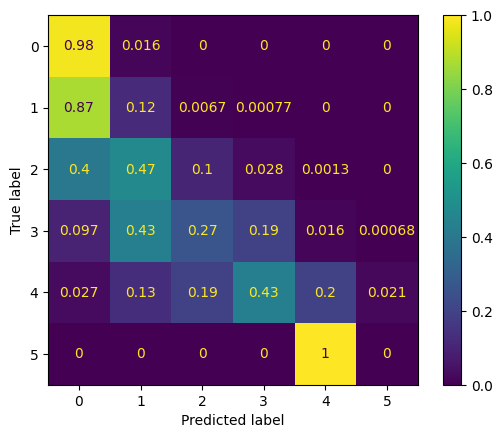

fw70b vs og
hplt
paired-no_hplt.json
fw8b vs askllm
SignificanceResult(statistic=0.17286439171445878, pvalue=1.3788150994471752e-298)
0 0.0224 0.0192 0.0052 0.0989 0.0129    475
1 0.0281 0.0242 0.0033 0.3493 0.0165  39834
2 0.0382 0.0322 0.0055 0.3367 0.0255   4528
3 0.0373 0.0279 0.0081 0.4068 0.0391    127
fw70b vs askllm
fw8b vs fw70b
fw70b vs og
da
c4
paired-da_c4.json


/home/robin/miniconda3/envs/huggingface/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robin/miniconda3/envs/huggingface/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


fw8b vs askllm
SignificanceResult(statistic=0.5515767066251126, pvalue=0.0)
0 0.0059 0.0030 0.0000 0.2938 0.0104 114765
1 0.0195 0.0087 0.0000 0.4333 0.0283 103558
2 0.0422 0.0269 0.0000 0.4348 0.0441  26867
3 0.0851 0.0689 0.0000 0.4930 0.0665  16756
4 0.1228 0.1109 0.0019 0.3911 0.0740    432
5 0.1596 0.1520 0.0178 0.3006 0.0840     11


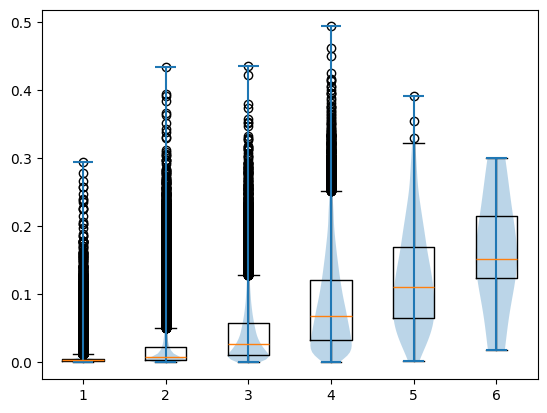

fw70b vs askllm
SignificanceResult(statistic=0.5773528692827457, pvalue=0.0)
0 0.0109 0.0044 0.0000 0.4254 0.0191 279188
1 0.0423 0.0259 0.0000 0.4490 0.0461  87516
2 0.0610 0.0434 0.0000 0.4474 0.0570  40220
3 0.0976 0.0826 0.0000 0.5692 0.0712  22636
4 0.1333 0.1214 0.0020 0.4612 0.0791   2187
5 0.1452 0.1334 0.0331 0.2826 0.0748     39


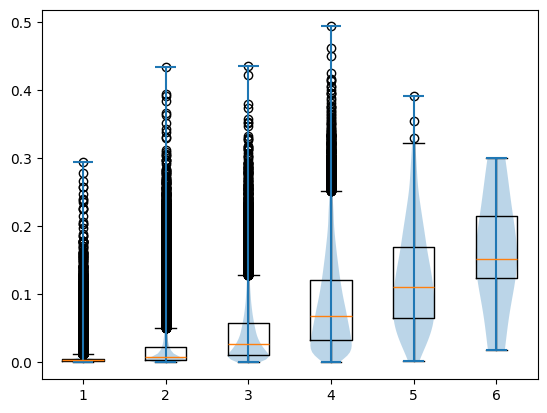

fw8b vs fw70b
PearsonRResult(statistic=0.6424379816174025, pvalue=0.0)
[[0.97 0.03 0.   0.   0.   0.  ]
 [0.71 0.23 0.05 0.01 0.   0.  ]
 [0.29 0.43 0.22 0.06 0.   0.  ]
 [0.07 0.33 0.31 0.27 0.03 0.  ]
 [0.02 0.15 0.25 0.41 0.17 0.  ]
 [0.   0.1  0.4  0.2  0.3  0.  ]]


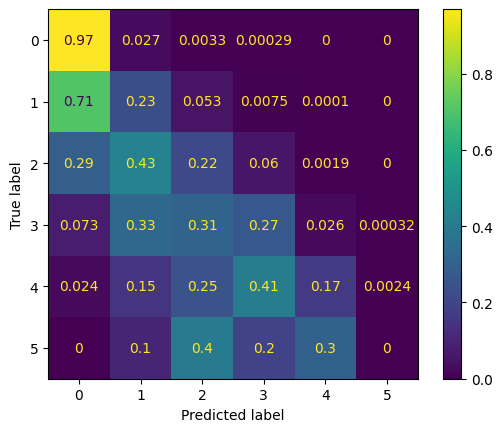

fw70b vs og
PearsonRResult(statistic=0.7461057797202066, pvalue=0.0)
[[0.41 0.54 0.04 0.   0.   0.  ]
 [0.01 0.48 0.46 0.05 0.01 0.  ]
 [0.   0.19 0.58 0.2  0.03 0.  ]
 [0.   0.04 0.29 0.36 0.29 0.02]
 [0.   0.02 0.15 0.12 0.61 0.11]
 [0.   0.   0.5  0.   0.5  0.  ]]


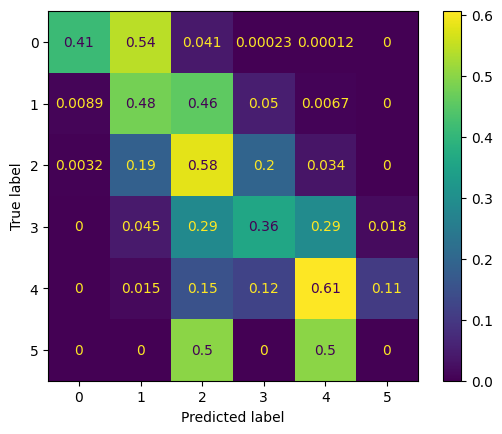

oscar
paired-da_oscar.json
fw8b vs askllm
SignificanceResult(statistic=0.5373426721032692, pvalue=0.0)
0 0.0077 0.0033 0.0001 0.2112 0.0137   9323
1 0.0190 0.0081 0.0000 0.3883 0.0286  16487
2 0.0416 0.0255 0.0004 0.3848 0.0447   5522
3 0.0845 0.0696 0.0007 0.4098 0.0643   4054
4 0.1344 0.1328 0.0039 0.2972 0.0684    122
fw70b vs askllm
SignificanceResult(statistic=0.5681887662025561, pvalue=0.0)


/home/robin/miniconda3/envs/huggingface/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robin/miniconda3/envs/huggingface/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0 0.0138 0.0055 0.0000 0.3883 0.0224  38259
1 0.0458 0.0292 0.0000 0.4696 0.0481  16400
2 0.0653 0.0491 0.0004 0.4222 0.0582   8069
3 0.1014 0.0887 0.0005 0.4593 0.0711   4948
4 0.1433 0.1372 0.0051 0.4862 0.0750    478
5 0.1901 0.1861 0.1122 0.2841 0.0493     12
fw8b vs fw70b
PearsonRResult(statistic=0.6298508219895427, pvalue=0.0)
[[0.95 0.04 0.01 0.   0.   0.  ]
 [0.75 0.2  0.05 0.01 0.   0.  ]
 [0.31 0.45 0.19 0.05 0.   0.  ]
 [0.08 0.35 0.3  0.25 0.02 0.  ]
 [0.02 0.2  0.16 0.48 0.11 0.02]
 [0.   0.   0.   0.   0.   0.  ]]


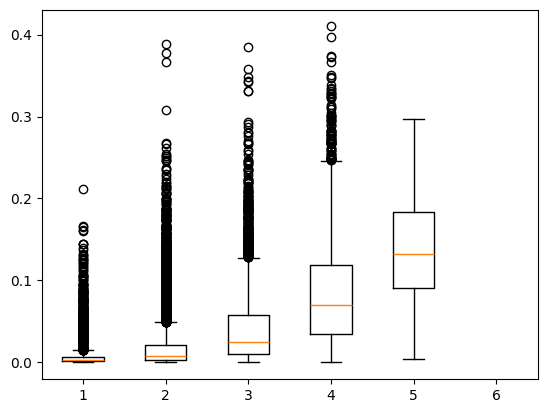

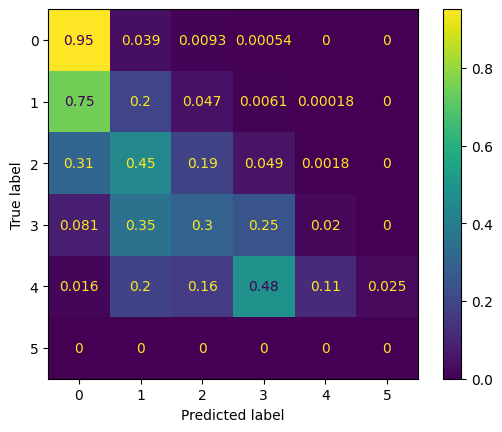

fw70b vs og
hplt
paired-da_hplt.json
fw8b vs askllm
SignificanceResult(statistic=0.4618357790565231, pvalue=0.0)
0 0.0064 0.0034 0.0000 0.2559 0.0091  25543
1 0.0162 0.0090 0.0000 0.3255 0.0202  42895
2 0.0301 0.0199 0.0000 0.3352 0.0309  12806
3 0.0560 0.0426 0.0010 0.3640 0.0485   4853
4 0.0804 0.0661 0.0125 0.3378 0.0513     99
5 0.0959 0.0959 0.0029 0.1890 0.0931      2


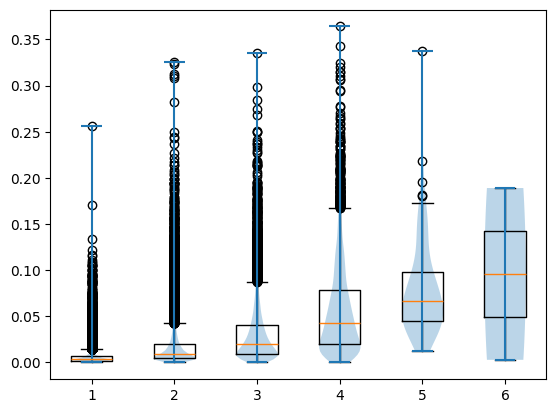

fw70b vs askllm
fw8b vs fw70b
fw70b vs og


In [19]:
for lang in langs:
    print(lang)
    for flavour in flavours:
        print(flavour)
        compare_all(lang, flavour)